Install dependencies

In [1]:
# Copyright (c) 2025, NVIDIA CORPORATION.  All rights reserved.

# Required Libraries
import argparse
import math
import os
from functools import partial
from typing import Any
import torch

import nemo_run as run
from lightning.pytorch.callbacks import Callback

from nemo.collections import llm
from nemo.collections.llm.recipes.callbacks.common import straggler_det_callback
from nemo.lightning.run import plugins

from crash_simulator import CrashSimulationCallback


print("Required libraries loaded.")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[NeMo W 2025-02-28 20:32:58 nemo_logging:361] /usr/local/lib/python3.10/dist-packages/pyannote/core/notebook.py:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
      cm = get_cmap("Set1")
    


Required libraries loaded.


Define and initialize a local executor, which is used to manage distributed computing tasks. The executor encapsulates configurations for launching jobs (e.g. number of devices, environment variables, task distribution).

Executor setup complete.


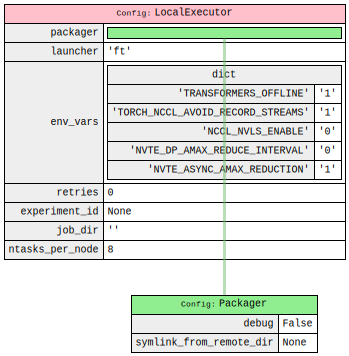

In [2]:
def local_executor(devices: int = 2) -> run.LocalExecutor:
    """
    Factory method for creating a LocalExecutor instance. 
    This sets up environment variables and configures the number of devices.

    Args:
        devices (int): Number of devices to be used per node.

    Returns:
        run.LocalExecutor: Configured local executor object.
    """
    env_vars = {
        "TRANSFORMERS_OFFLINE": "1",   # Run Transformer models offline
        "TORCH_NCCL_AVOID_RECORD_STREAMS": "1",  # Optimize PyTorch NCCL
        "NCCL_NVLS_ENABLE": "0",      # Experimental NCCL environment variable
        "NVTE_DP_AMAX_REDUCE_INTERVAL": "0", 
        "NVTE_ASYNC_AMAX_REDUCTION": "1",
    }
    # Create LocalExecutor with the `ft` launcher
    executor = run.LocalExecutor(ntasks_per_node=devices, launcher="ft", env_vars=env_vars)
    return executor

# Initialize the executor based on the arguments
executor = local_executor(8)

print("Executor setup complete.")
executor

## Model Recipe Setup
Load and configure the LLAMA pretrain recipe. We apply optional configurations
such as:
1. Enabling callbacks for straggler detection.
2. Adding fault tolerance plugins.
3. Updating training configurations for demonstration purposes.

In [3]:
# Create a small LLAMA3 model configuration
# TODO: Add info on current model size and how to change model size
def small_llama_cfg() -> llm.GPTConfig:
    """Small 180m model"""
    return run.Config(
        llm.Llama3Config8B,
        rotary_base=500_000,
        seq_length=128,
        num_layers=4,
        hidden_size=768,
        ffn_hidden_size=2688,
        num_attention_heads=16,
        init_method_std=0.023,
    )


Create a pretrain recipe

In [4]:
# Experiment name
exp_name = "resiliency-in-pretraining-demo"

# Preliminary setup for the LLAMA pretrain recipe
# TODO: Add info on how to change num_nodes and num_gpus_per_node
pretrain = partial(llm.llama31_8b.pretrain_recipe, num_nodes=1, num_gpus_per_node=8)(
    name=exp_name, dir="/tmp/nemo_run/checkpoints"
)
# Use smaller LLAMA model for faster execution
pretrain.model = run.Config(llm.LlamaModel, small_llama_cfg())

# TODO: Add info on Straggler Detection callback, Preemption Plugin, Fault Tolerance Plugin

In [5]:
# use CP=1 TP=2
pretrain.trainer.strategy.tensor_model_parallel_size = 2
pretrain.trainer.strategy.context_parallel_size = 1

# Automatically detect and mitigate stragglers during training
pretrain.trainer.callbacks.append(straggler_det_callback(straggler_report_time_interval=1))

# Add runtime plugins (e.g., preemption and fault tolerance)
run_plugins = [plugins.PreemptionPlugin()]
run_plugins.append(plugins.FaultTolerancePlugin())

# Disable validation sanity checks to reduce startup time
pretrain.trainer.num_sanity_val_steps = 0

# Limit the number of training steps for a concise demo
max_steps = 20
pretrain.broadcast(max_steps=max_steps)
pretrain.trainer.limit_val_batches = 2
pretrain.trainer.log_every_n_steps = 1
pretrain.trainer.val_check_interval = 10

# Confirm that recipe setup is complete
print("Model recipe setup complete.")


Model recipe setup complete.


In [6]:
# TODO: Add info on what these env variables are for
# Setup ENV
os.environ["FAULT_TOL_CFG_PATH"] = "/tmp/sample_job_ft_cfg.yml"
os.environ["FAULT_TOL_FINISHED_FLAG_FILE"] = "/tmp/sample_job_finished_flag"

## Running the Experiment
Run the entire pretraining experiment. Depending on the arguments passed:
- If `dryrun` is True, it performs a dry run (to validate configurations).
- Otherwise, it launches the actual training run locally.

In [7]:
def run_experiment(exp_name, pretrain, executor, run_plugins, dryrun=False):
    """
    Run the pretraining experiment either as a dry run or actual training.
    
    Args:
        exp_name: Name of the experiment
        pretrain: Pretrain configuration object
        executor: Executor to run the experiment
        run_plugins: List of runtime plugins
        dryrun: Boolean flag to perform a dry run
    """
    with run.Experiment(f"{exp_name}") as exp:
        # Add the pretrain job to the experiment
        exp.add(
            pretrain,
            executor=executor,
            name=exp_name,
            plugins=run_plugins,
            tail_logs=True,
        )

        # Execute the experiment based on the dryrun flag
        if dryrun:
            print("Performing dry run ...")
            exp.dryrun()
        else:
            print("Launching training run ...")
            exp.run(sequential=True, detach=True)
            print("Experiment executed successfully.")

In [ ]:
# run the experiment
run_experiment(exp_name, pretrain, executor, run_plugins, dryrun=False)

In [ ]:
# Enable a crash simulation callback
pretrain.trainer.callbacks.append(run.Config(CrashSimulationCallback, crash_step=17))

# run the experiment
run_experiment(exp_name, pretrain, executor, run_plugins, dryrun=False)

────── Entering Experiment resiliency-in-pretraining-demo with id: resiliency-in-pretraining-demo_1740774781 ──────

Launching training run ...


[20:33:01]  Cannot detach from this experiment. Please keep it running until completion.          ]8;id=169399;file:///opt/NeMo-Run/src/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=908529;file:///opt/NeMo-Run/src/nemo_run/run/experiment.py#651\651]8;;\

Log directory is: /root/.nemo_run/experiments/resiliency-in-pretraining-demo/resiliency-in-pretraining-demo_1740774781/resiliency-in-pretraining-demo


           Launching job resiliency-in-pretraining-demo for experiment                            ]8;id=640043;file:///opt/NeMo-Run/src/nemo_run/run/experiment.py\experiment.py]8;;\:]8;id=756850;file:///opt/NeMo-Run/src/nemo_run/run/experiment.py#724\724]8;;\
           resiliency-in-pretraining-demo                                                                          

Log directory is: /root/.nemo_run/experiments/resiliency-in-pretraining-demo/resiliency-in-pretraining-demo_1740774781/resiliency-in-pretraining-demo
Launched app: local_persistent://nemo_run/resiliency-in-pretraining-demo-dwj3fvbzxhz5p
AppStatus:
    State: RUNNING
    Num Restarts: 0
    Roles: 
    Msg: <NONE>
    Structured Error Msg: <NONE>
    UI URL: file:///root/.nemo_run/experiments/resiliency-in-pretraining-demo/resiliency-in-pretraining-demo_1740774781/resiliency-in-pretraining-demo/nemo_run/resiliency-in-pretraining-demo-dwj3fvbzxhz5p
    


Experiment executed successfully.


─────────────────── Waiting for Experiment resiliency-in-pretraining-demo_1740774781 to finish ────────────────────

Experiment Status for resiliency-in-pretraining-demo_1740774781

Task 0: resiliency-in-pretraining-demo
- Status: RUNNING
- Executor: LocalExecutor
- Job id: resiliency-in-pretraining-demo-dwj3fvbzxhz5p
- Local Directory: /root/.nemo_run/experiments/resiliency-in-pretraining-demo/resiliency-in-pretraining-demo_1740774781/resiliency-in-pretraining-demo

Waiting for job resiliency-in-pretraining-demo-dwj3fvbzxhz5p to finish [log=True]...


ining-demo/0 [2025-02-28 20:33:02,664] [WARNING] [ft_launcher@c032f989068c] master_addr is only used for static rdzv_backend and when rdzv_endpoint is not specified.
ining-demo/0 [2025-02-28 20:33:02,664] [WARNING] [ft_launcher@c032f989068c] 
ining-demo/0 *****************************************
ining-demo/0 Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
ining-demo/0 *****************************************
ining-demo/0 [2025-02-28 20:33:02,669] [INFO] [ft_launcher@c032f989068c] [default] starting workers for entrypoint: python
ining-demo/0 [2025-02-28 20:33:02,669] [INFO] [ft_launcher@c032f989068c] [default] Rendezvous'ing worker group
ining-demo/0 [2025-02-28 20:33:02,964] [INFO] [ft_launcher@c032f989068c] [default] Rendezvous complete for workers. Result:
ining-demo/0   restart_count=0
ining-demo/0   master_addr=c032f989